# Антон Стюхин
# ДЗ - 7. Анализ данных : предсказание инсульта

Наша задача - проанализировать датасет, в котором каждый объект - человек, а таргет - перенес ли он инсульт. Хотя датасет и наша работа с точки зрения медицины довольно наивны, важность проблемы трудно переоценить. Выявление факторов риска подобных кондишнов является важной задачей современной доказательной медицины.


Датасет был взят с kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Источник стоит конфиденциальный, датасет предназначен для использовая исключительно в образовательных целях
Я выбрал этот датасет, потому что в нем содержится информация по большому количеству признаков, а также не мало объектов, что делает выборку достаточно крупной для качественного анализа.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv("stroke.csv")
df = df.drop("id", axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [3]:
df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Посмотрим на наши данные. Здесь названия фичей интуитивны, за исключением bmi = body mass index. Заметим, что наши данные неполны - у 210 объектов отсутствует информация об индексе массы тела. Используем KNN imputer, чтобы решить эту проблему

In [5]:
df.replace('NaN', np.nan, inplace=True)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df['bmi'] = imputer.fit_transform(df[['bmi']])
df['bmi'] = pd.Series(df['bmi'])
df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


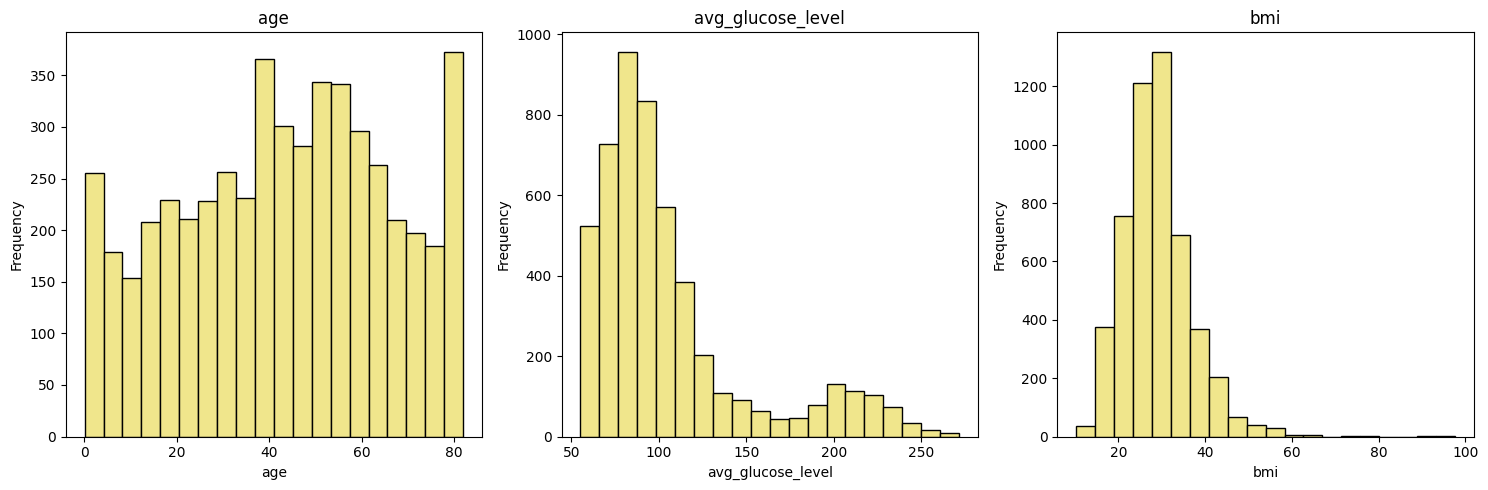

In [6]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    df[feature].plot(kind='hist', bins=20, edgecolor='black', color = 'khaki')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [7]:
df.describe(exclude = 'object')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Мы видим, что распределение по возрасту у нас примерно равномерное, BMI distribution скорее нормальное, а уровень глюкозы в крови тоже принимает почти нормальное распределение с небольшим подъемом при высоких значениях

Распределения остальных признаков не описать, потому что они принимают бинарные значения (ну или 3/4). Какие-то из них более равномерно распределены, какие-то - менее.

Из общих соображений можно сказать, что выборка вряд является совсем уж репрезентативной: например, медианный ИМТ находится на уровне около 28.5, что почти соответствует нижней грани ожирения (https://www.who.int/ru/news-room/fact-sheets/detail/obesity-and-overweight), что также может говорить о нерепрезентативности. Еще один фактор - распределение мест проживания: почти поровну между городским и загородным, что также не соответствует более урбанизированным Европейским/Северо-Американским обществам.


Сформулируем несколько гипотез, которые попробуем доказать/опровергнуть:
1. У мужчин выше риск получения инсульта
2. Чем старше человек, тем выше риск инсульта
3. Гипертония и заболевания сердца повышают риск инсульта
4. Тип работы вряд ли связан с инсультом
5. Население городов чаще подвержено инсультам
6. Чем выше среднее содержание сахара в крови, тем выше риск инсульта
7. Чем выше индекс массы тела, тем выше риск инсульта
8. Активные курильщики должны иметь больший риск инсульта

Посмотрим, как распределен таргет

Text(0.5, 1.0, 'Stroke')

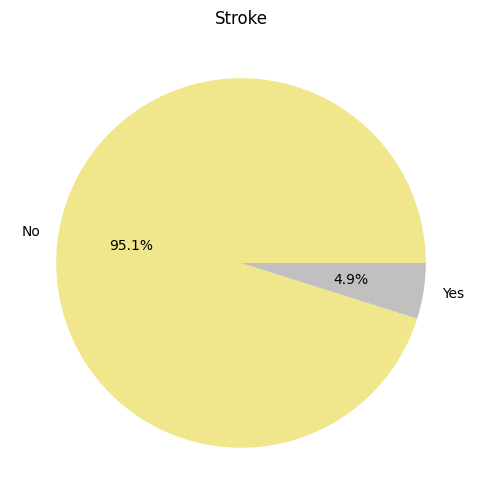

In [8]:
stroke_counts = df['stroke'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(stroke_counts, labels=['No', 'Yes'], autopct='%1.1f%%', colors = ['khaki', 'silver'])
plt.title('Stroke')

Видим явный дизбаланс классов у таргетной переменной. Учтем это при выборе корректной метрики качества, робастной к дизбалансу классов.

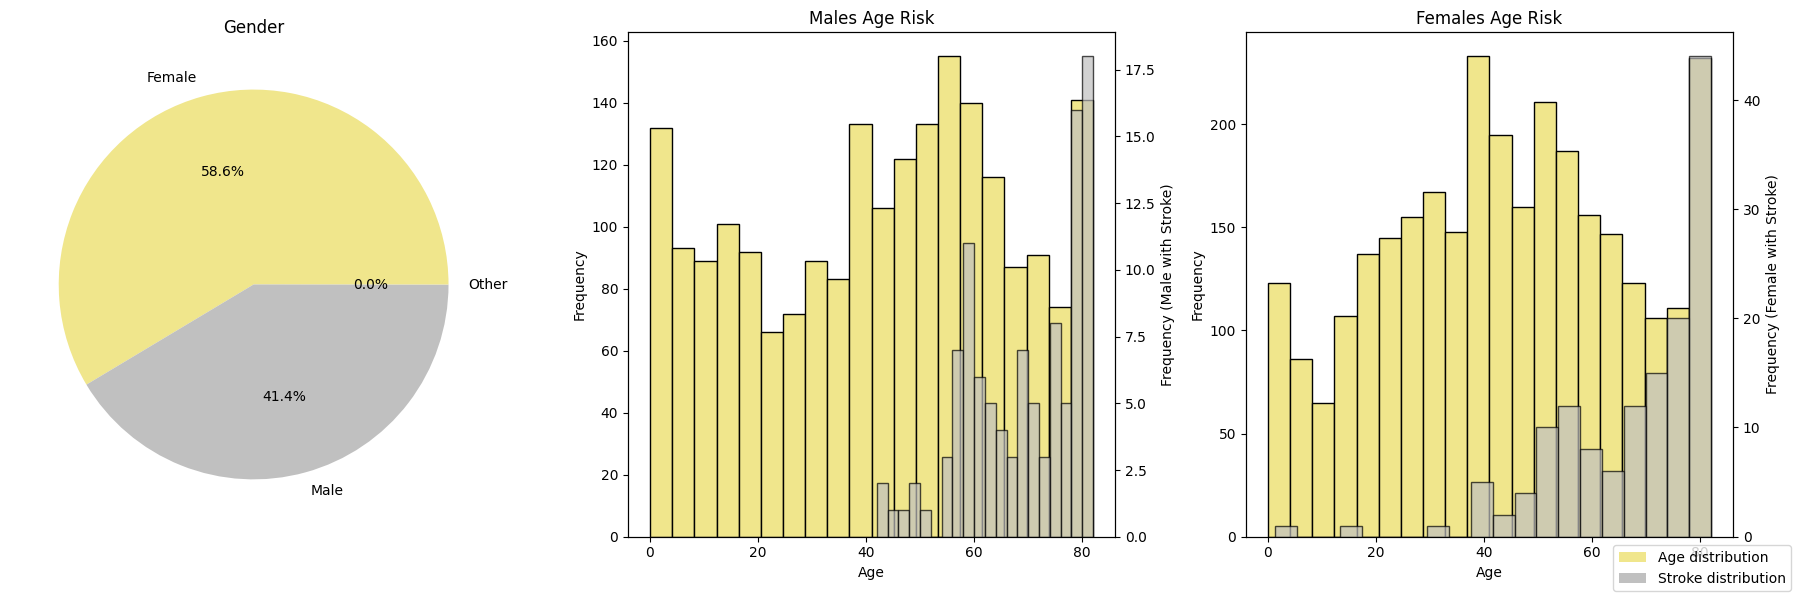

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


gender_counts = df['gender'].value_counts()
axs[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors = ['khaki', 'silver'])
axs[0].set_title('Gender')

male_df = df[df['gender'] == 'Male']
male_stroke_df = male_df[male_df['stroke'] == 1]
axs[1].hist(male_df['age'], bins = 20, color = 'khaki', edgecolor = 'black')
ax1 = axs[1].twinx()
ax1.hist(male_stroke_df['age'], bins = 20, color='silver', edgecolor='black', label='Male with Stroke', alpha = 0.7)
ax1.set_ylabel('Frequency (Male with Stroke)')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Males Age Risk')


female_df = df[df['gender'] == 'Female']
female_stroke_df = female_df[female_df['stroke'] == 1]
axs[2].hist(female_df['age'], bins = 20, color = 'khaki', edgecolor = 'black')
ax2 = axs[2].twinx()
ax2.hist(female_stroke_df['age'], bins = 20, color='silver', edgecolor='black', label='Female with Stroke', alpha = 0.7)
ax2.set_ylabel('Frequency (Female with Stroke)')
axs[2].set_xlabel('Age')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Females Age Risk')
fig.legend(['Age distribution', 'Stroke distribution'], loc='lower right')
plt.tight_layout()

Видим, что возраст является важным признаком, положительно связанным с вероятностью наступления инсульта, что согласуется с логикой. Этот эффект более заметен у женщин, чем у мужчин

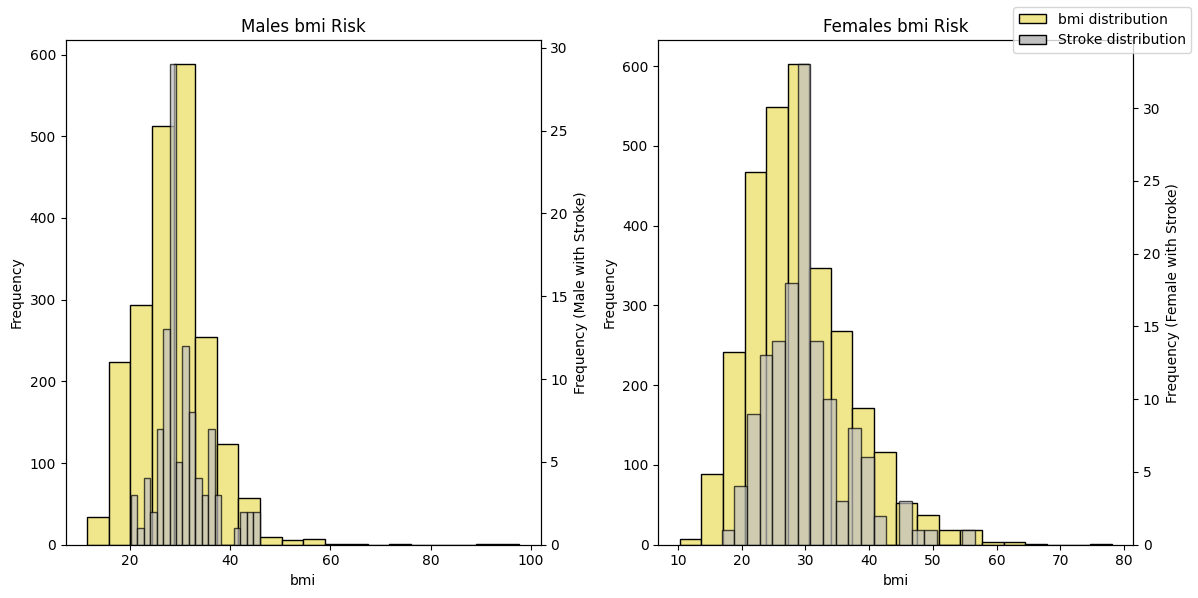

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(male_df['bmi'], bins = 20, color = 'khaki', edgecolor = 'black')
ax1 = axs[0].twinx()
ax1.hist(male_stroke_df['bmi'], bins = 20, color='silver', edgecolor='black', label='Male with Stroke', alpha = 0.7)
ax1.set_ylabel('Frequency (Male with Stroke)')
axs[0].set_xlabel('bmi')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Males bmi Risk')



axs[1].hist(female_df['bmi'], bins = 20, color = 'khaki', edgecolor = 'black')
ax2 = axs[1].twinx()
ax2.hist(female_stroke_df['bmi'], bins = 20, color='silver', edgecolor='black', label='Female with Stroke', alpha = 0.7)
ax2.set_ylabel('Frequency (Female with Stroke)')
axs[1].set_xlabel('bmi')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Females bmi Risk')
legend_colors = ['khaki', 'silver']
legend_labels = ['bmi distribution', 'Stroke distribution']
fig.legend(handles=[plt.Rectangle((0,0),1,1,color=color,ec="k") for color in legend_colors], labels=legend_labels, loc='upper right')
plt.tight_layout()

Более высокий индекс массы тела указывает на более высокий шанс инсульта

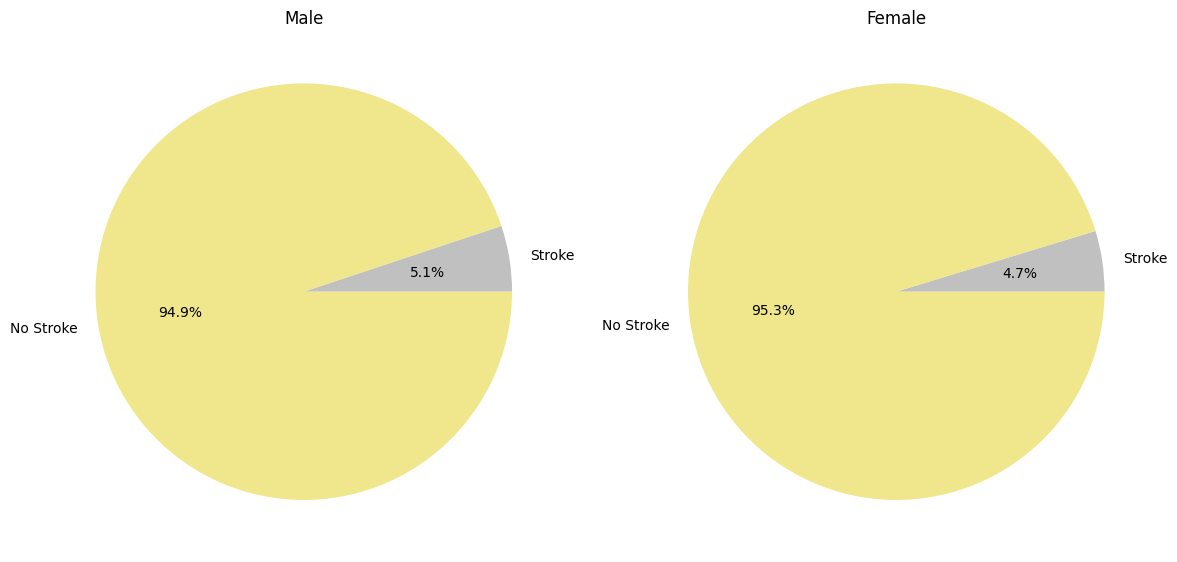

In [11]:
genders = ['Male', 'Female']

fig, axs = plt.subplots(1, len(genders), figsize=(12, 6))

for i, gender in enumerate(genders):
    with_gender = df[df['gender'] == gender]
    without_gender = df[df['gender'] != gender]
    strokes_with_gender = with_gender['stroke'].sum()
    strokes_without_gender = without_gender['stroke'].sum()
    total_with_gender = len(with_gender)
    total_without_gender = len(without_gender)
    share_with_gender = strokes_with_gender / total_with_gender * 100
    share_without_gender = strokes_without_gender / total_without_gender * 100
    axs[i].pie([share_with_gender, 100 - share_with_gender], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
    axs[i].set_title(gender)

plt.tight_layout()
plt.show()


Видим, что риск возникновения инсульта у мужчин примерно такой же, как у женщин

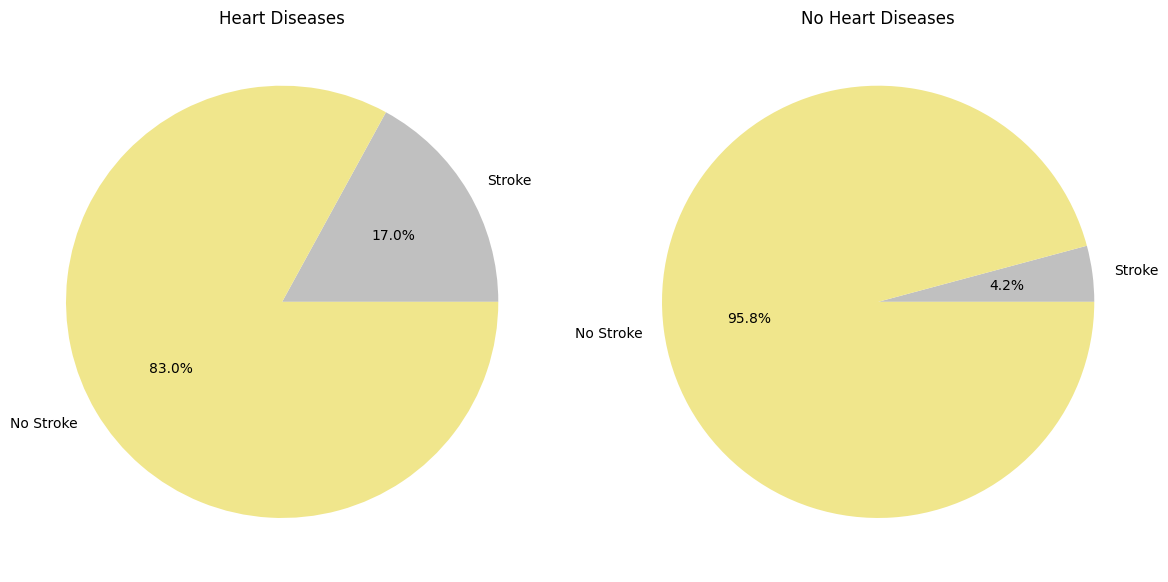

In [12]:
with_heart_disease = df[df['heart_disease'] == 1]
without_heart_disease = df[df['heart_disease'] == 0]
strokes_with_heart_disease = with_heart_disease['stroke'].sum()
strokes_without_heart_disease = without_heart_disease['stroke'].sum()
total_with_heart_disease = len(with_heart_disease)
total_without_heart_disease = len(without_heart_disease)
share_with_heart_disease = strokes_with_heart_disease / total_with_heart_disease * 100
share_without_heart_disease = strokes_without_heart_disease / total_without_heart_disease * 100


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].pie([share_with_heart_disease, 100 - share_with_heart_disease], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
axs[0].set_title('Heart Diseases')
axs[1].pie([share_without_heart_disease, 100 - share_without_heart_disease], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
axs[1].set_title('No Heart Diseases')

plt.tight_layout()

Можем с уверенностью сделать вывод, что заболевания сердца значительно повышают риск инсульта

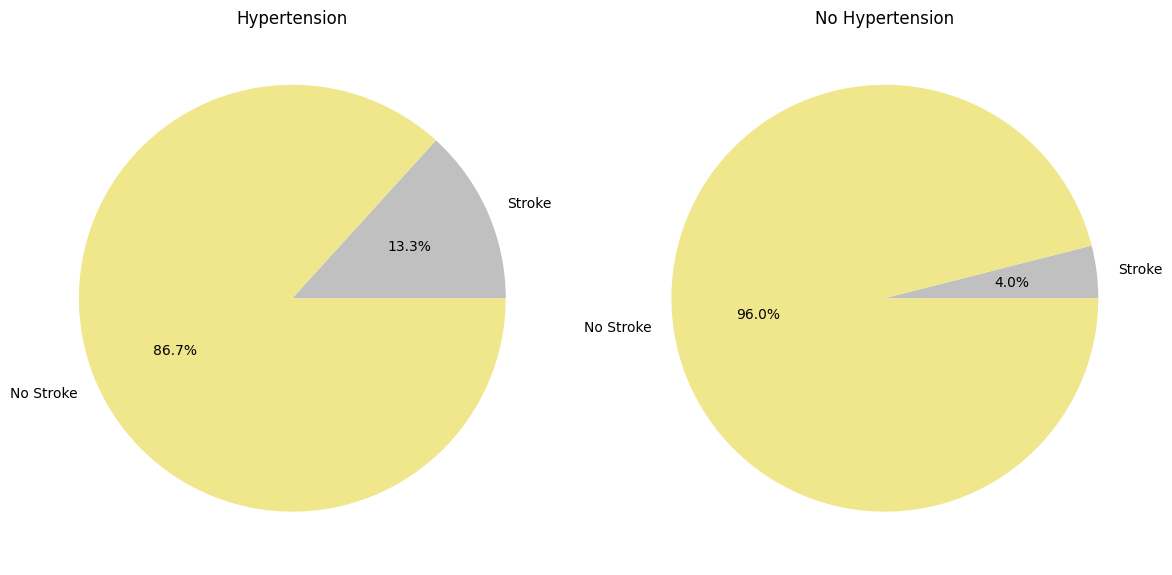

In [13]:
hypertension = df[df['hypertension'] == 1]
no_hypertension = df[df['hypertension'] == 0]
strokes_hypertension = hypertension['stroke'].sum()
strokes_no_hypertension = no_hypertension['stroke'].sum()
total_hypertension = len(hypertension)
total_no_hypertension = len(no_hypertension)
share_hypertension = strokes_hypertension / total_hypertension * 100
share_no_hypertension = strokes_no_hypertension / total_no_hypertension * 100


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].pie([share_hypertension, 100 - share_hypertension], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
axs[0].set_title('Hypertension')
axs[1].pie([share_no_hypertension, 100 - share_no_hypertension], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
axs[1].set_title('No Hypertension')

plt.tight_layout()

Гипертония также связана с повышенным риском инсультов, хотя связь не так сильна, как у заболеваний сердца

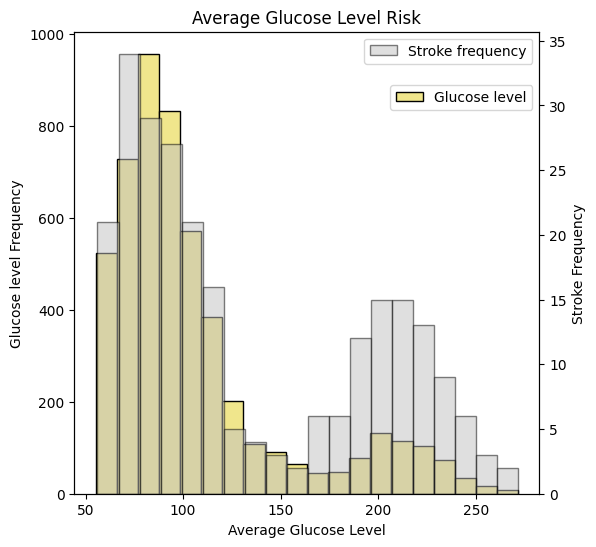

In [14]:
fig, axs = plt.subplots(1, figsize=(6, 6))    
ax3 = axs.twinx()
ax3.hist(df[df['stroke'] == 1]['avg_glucose_level'], bins=20, color='silver', edgecolor='black', alpha=0.5, label='Stroke')
ax3.set_ylabel('Stroke Frequency')
ax3.legend(['Stroke frequency'], loc='upper right')
axs.hist(df['avg_glucose_level'], bins=20, color='khaki', edgecolor='black')
axs.set_title('Average Glucose Level Risk')
axs.set_xlabel('Average Glucose Level')
axs.set_ylabel('Glucose level Frequency')
axs.legend(['Glucose level'], loc='upper right', bbox_to_anchor = (1, 0.9))

Средний уровень глюкозы является важным признаком, положительно скоррелированным с инсультом

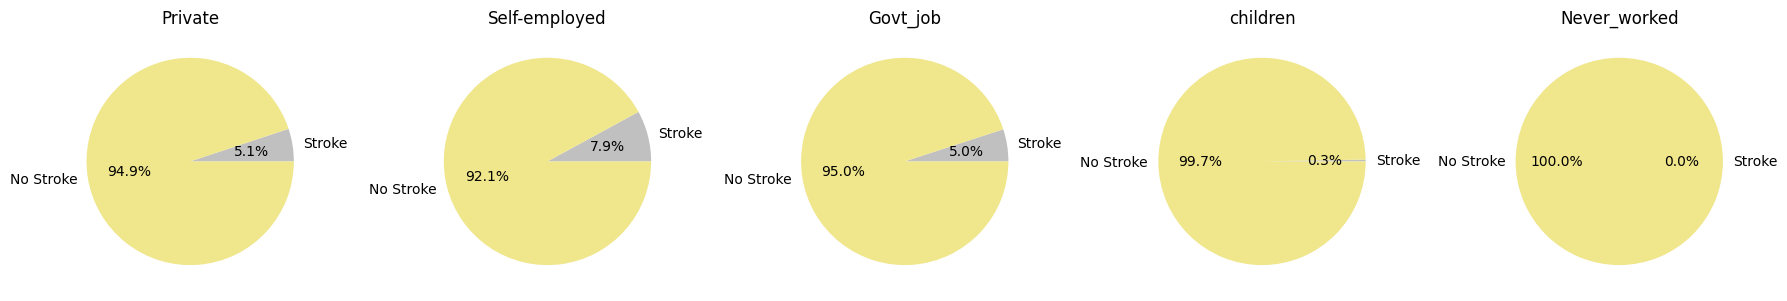

In [15]:
work_types = df['work_type'].unique()

fig, axs = plt.subplots(1, len(work_types), figsize=(18, 10))

for i, work_type in enumerate(work_types):
    with_work_type = df[df['work_type'] == work_type]
    strokes_with_work_type = with_work_type['stroke'].sum()
    total_with_work_type = len(with_work_type)
    share_with_work_type = strokes_with_work_type / total_with_work_type * 100
    axs[i].pie([share_with_work_type, 100 - share_with_work_type], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
    axs[i].set_title(work_type)

plt.tight_layout()


Здесь есть несколько интересных моментов:
1. У детей почти не бывает инсультов. Опять же, это мы уже знаем из-за связи возраста и таргета
2. У тех, кто никогда не работал, не было инсульта. В отсутствие других показателей, можно предположить, что это финансово благополучные люди, которые имеют доступ к более качественному здравоохранению
3. Самозанятые (в широком смысле слова) люди имеют более высокий риск инсульта. Это может быть связано с большим количеством стресса, вызванного персональными рисками, которые им приходится брать на себя в отсутствие работодателя

Таким образом, тип работы имеет связь с риском возникновения инсульта

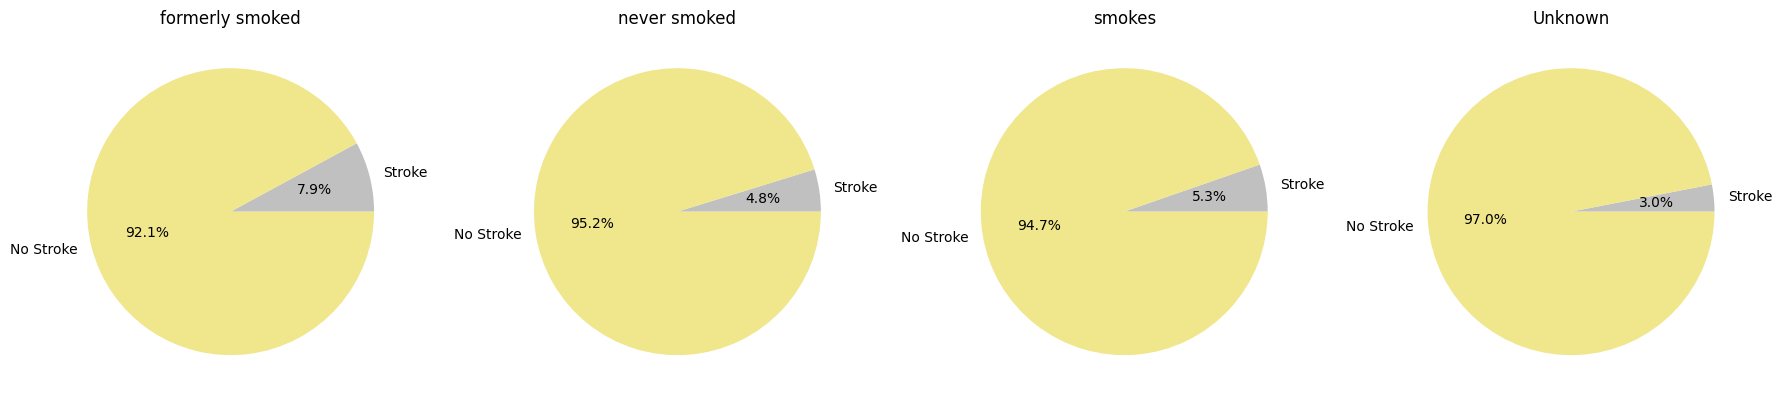

In [16]:
smoking_statuses = df['smoking_status'].unique()

fig, axs = plt.subplots(1, len(smoking_statuses), figsize=(18, 6))

for i, smoking_status in enumerate(smoking_statuses):
    with_smoking_status = df[df['smoking_status'] == smoking_status]
    strokes_with_smoking_status = with_smoking_status['stroke'].sum()
    total_with_smoking_status = len(with_smoking_status)  
    share_with_smoking_status = strokes_with_smoking_status / total_with_smoking_status * 100 
    axs[i].pie([share_with_smoking_status, 100 - share_with_smoking_status], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
    axs[i].set_title(smoking_status)
    
plt.tight_layout()



У людей, которые никогда не курили, инсульты наступали реже. Любопытно, что самый высокий риск инсульта выявлен у тех, кто курил ранее, но бросил. Этот риск даже выше, чем у действующих курильщиков. Возможно, дело в стаже курения, однако данные не предоставляют нам полной картины

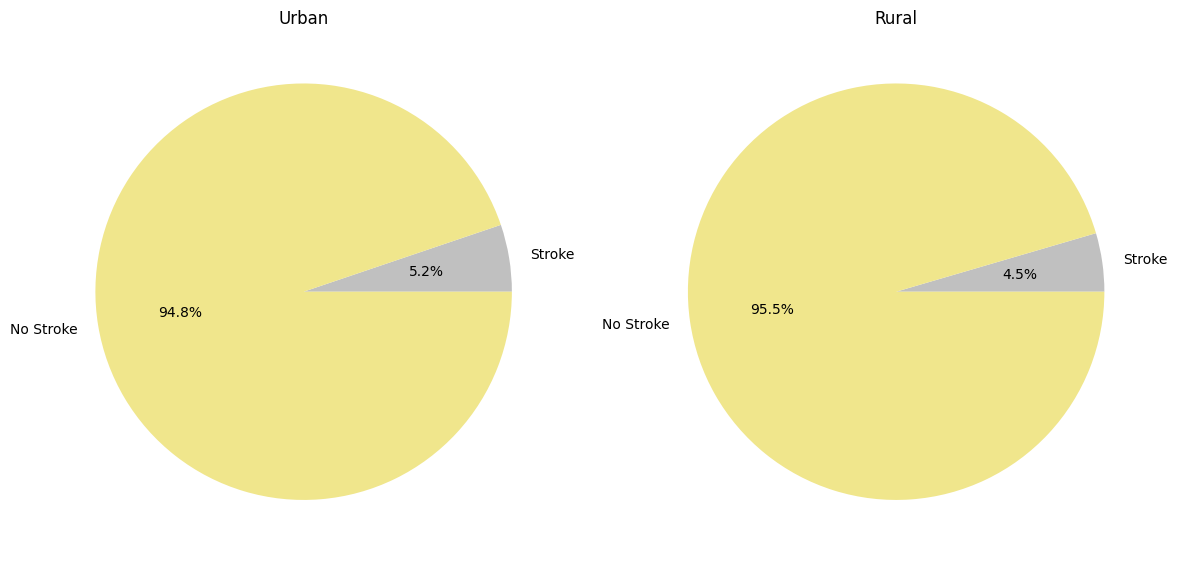

In [17]:
residence_types = df['Residence_type'].unique()

fig, axs = plt.subplots(1, len(residence_types), figsize=(12, 6))

for i, residence_type in enumerate(residence_types):
    with_residence_type = df[df['Residence_type'] == residence_type]
    strokes_with_residence_type = with_residence_type['stroke'].sum()
    total_with_residence_type = len(with_residence_type)    
    share_with_residence_type = strokes_with_residence_type / total_with_residence_type * 100 
    axs[i].pie([share_with_residence_type, 100 - share_with_residence_type], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
    axs[i].set_title(residence_type)

plt.tight_layout()


Место проживания, по-видимому, не имеет сильной связи с инсультом, что частично опровергает нашу гипотезу

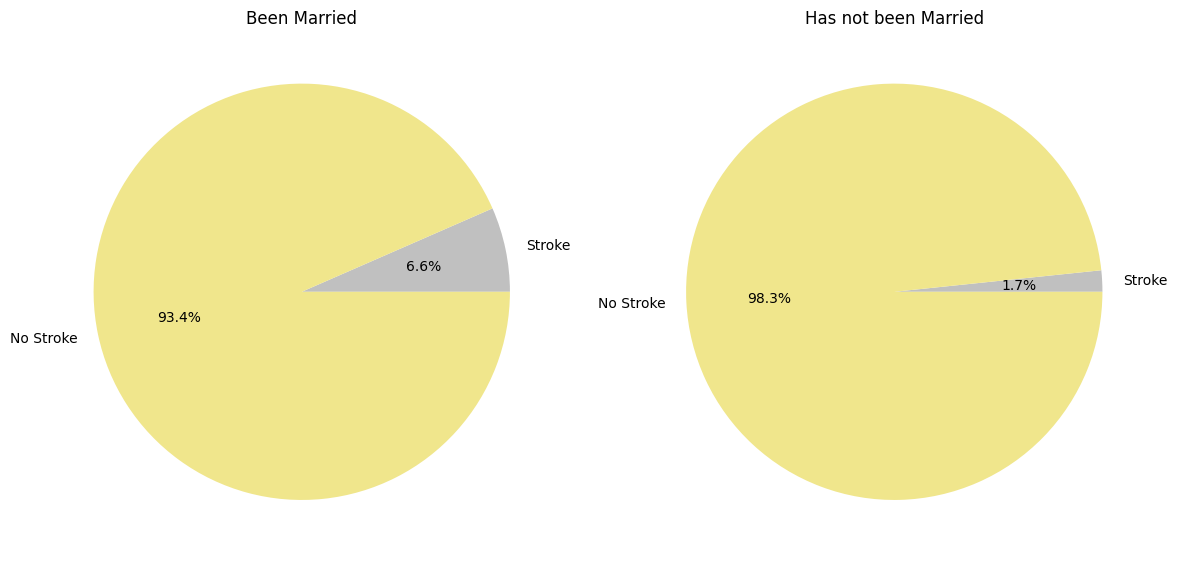

In [18]:
ever_married_statuses = df['ever_married'].unique()

fig, axs = plt.subplots(1, len(ever_married_statuses), figsize=(12, 6))

for i, ever_married_status in enumerate(ever_married_statuses):
    with_ever_married_status = df[df['ever_married'] == ever_married_status]
    strokes_with_ever_married_status = with_ever_married_status['stroke'].sum()
    total_with_ever_married_status = len(with_ever_married_status)
    share_with_ever_married_status = strokes_with_ever_married_status / total_with_ever_married_status * 100
    title = "Been Married" if ever_married_status == "Yes" else "Has not been Married"
    axs[i].pie([share_with_ever_married_status, 100 - share_with_ever_married_status], labels=['Stroke', 'No Stroke'], colors=['silver', 'khaki'], autopct='%1.1f%%')
    axs[i].set_title(title)
plt.tight_layout()




Существует связь между тем, был ли человек в браке и инсультом, однако, скорее всего, первая величина просто скоррелирована с возрастом, который, как мы видели ранее, связан с таргетом

Таким образом, можно сделать ряд выводов:

1. У мужчин риск возникновения инсульта действительно выше, однако разница крайне мала
2. Возраст - очень важный фактор. Чем старше человек, тем действительно выше риск инсульта
3. Гипертония и заболевания сердца действительно связаны с значительно повышенным риском инсульта
4. Самозанятость/работа на себя связана с более высоким риском возникновения инсульта. В других типах занятости значительной разницы нет
5. Население городов действительно немного чаще подвержено инсультам, хотя разница небольшая
6. Чем выше среднее содержание глюкозы в крови, тем выше риск возникновения инсульта
7. Высокий индекс массы тела положительно связан с повышенным риском инсульта
8. Действующие и бывшие курильщики чаще переносят инсульт

# ML

Преобразуем категориальные признаки. Поскольку будем использовать в том числе модели, работающие с расстоянием, label encoding нам не подойдет. Воспользуемся one-hot encoding для фичей: gender, ever_married, work_type, Residence_type, smoking_status.

In [19]:
df = pd.get_dummies(df, dtype=float, drop_first=True)
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

Здесь мы выбросили одну из колонок для каждой переменной, чтобы избежать проблем с переобучением при использовании линейных моделей

In [20]:
target = df['stroke']

In [21]:
df = df.drop('stroke', axis = 1)
df = df.join(target)

In [22]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'stroke'],
      dtype='object')

Разделим выборку на обучающую и тестовую и отнормируем наши признаки

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = df.drop('stroke', axis = 1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 54)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим классификаторы. В качестве метрики качества возьмем ROC AUC как робастную к дизбалансу классов

# Наш первый классификатор - KNN. 
KNN классификатор работает следующим образом: 
1. Отсортировать все объекты в порядке неубывания по выбранной метрике расстояния
2. Взять K первых из них и посмотреть, объектов какого класса больше всего. $y = argmax_c \sum_{j=1}^k [y_j =c]$, где y - метка класса нашего объекта, K - число соседей, y_j - метка класса j-го соседа, c - метка класса
3. Вероятности считаются делением суммы из предыдущей строки на k

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

Подберем оптимальное число соседей:

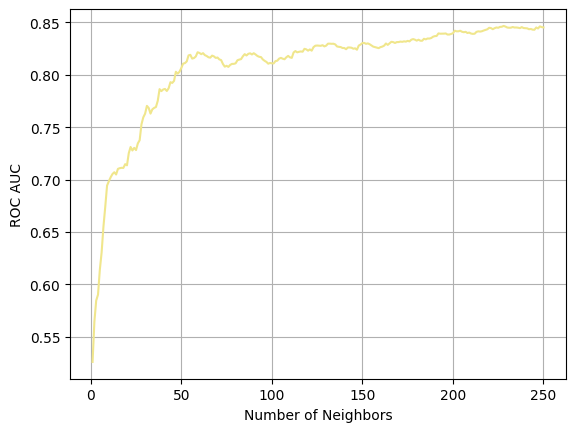

In [25]:
knn_accuracy_scores = []
for i in range(1, 251):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_scaled, y_train)
    knn_accuracy_scores.append(roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1]))

plt.plot(range(1, 251), knn_accuracy_scores, color = 'khaki')
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC AUC')
plt.grid(True)



In [26]:
print("Оптимальное число соседей :", np.argmax(knn_accuracy_scores) + 1)
print("Лучший ROC AUC:", np.max(knn_accuracy_scores))

Оптимальное число соседей : 228
Лучший ROC AUC: 0.8465430823385369


# Логрег

Логистическая регрессия - линейный классификатор, основанный на логистической функции потерь. \
Коротко о ней: Строим разделяющую поверхность (гиперплоскость) $Xw = 0$. Оптимизируемая функция определяется через отступы $M = yz$. Эта функция не гладкая, поэтому градиентный спуск применить не удастся. Заменяем ее верхней оценкой - лог лосс функцией: $L = -\frac{1}{n} \sum_{i=1}^{n} y_ilogy^*_i + (1-y_i)log(1-y^*_i).$ \
$y_i = \sigma(Xw)$, где $\sigma(z) = \frac{1}{1+e^{-z}}$. Здесь $y_i$ - вероятность класса i для нашего объекта

In [27]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)

In [28]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [29]:
logreg_accuracy = roc_auc_score(y_test,logreg.predict_proba(X_test_scaled)[:, 1])
logreg_accuracy

0.8701599326599327

In [30]:
print("ROC AUC на логреге:", logreg_accuracy)

ROC AUC на логреге: 0.8701599326599327


# Бустинг

Обучаем базовый классификатор, считаем градиент функции потерь по предсказаниям - это наши сдвиги, обучаем следующую базовую модель регресии на сдвигах, итеративно добавляем этот классификатор к предыдущему с некоторым оптимальном коэффициентом и получаем новый классификатор и новые сдвиги и т.д. пока не выполнен один из критериев остановки.

In [31]:
from catboost import CatBoostClassifier

In [32]:
iterations_values = [10, 15, 20, 25, 50, 75, 100]
learning_rate_values = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
depth_values = [2, 3, 4, 5]

best_roc_auc = 0
best_params = {}

for iterations in iterations_values:
    for learning_rate in learning_rate_values:
        for depth in depth_values:
            catboost_model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, random_state=19)
            catboost_model.fit(X_train, y_train)
            y_test_proba = catboost_model.predict_proba(X_test)[:, 1]  
            roc_auc = roc_auc_score(y_test, y_test_proba)
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_params = {'iterations': iterations, 'learning_rate': learning_rate, 'depth': depth}

0:	learn: 0.6728776	total: 59.8ms	remaining: 538ms
1:	learn: 0.6534550	total: 60.3ms	remaining: 241ms
2:	learn: 0.6352939	total: 60.8ms	remaining: 142ms
3:	learn: 0.6179466	total: 61.3ms	remaining: 91.9ms
4:	learn: 0.6014065	total: 61.5ms	remaining: 61.5ms
5:	learn: 0.5854538	total: 62.6ms	remaining: 41.7ms
6:	learn: 0.5703694	total: 63ms	remaining: 27ms
7:	learn: 0.5558770	total: 63.2ms	remaining: 15.8ms
8:	learn: 0.5418888	total: 64.3ms	remaining: 7.15ms
9:	learn: 0.5285133	total: 64.7ms	remaining: 0us
0:	learn: 0.6730848	total: 1.07ms	remaining: 9.65ms
1:	learn: 0.6538347	total: 1.58ms	remaining: 6.32ms
2:	learn: 0.6355334	total: 2.09ms	remaining: 4.88ms
3:	learn: 0.6182016	total: 2.71ms	remaining: 4.06ms
4:	learn: 0.6017069	total: 3.23ms	remaining: 3.23ms
5:	learn: 0.5858091	total: 3.72ms	remaining: 2.48ms
6:	learn: 0.5707578	total: 4.27ms	remaining: 1.83ms
7:	learn: 0.5563111	total: 4.79ms	remaining: 1.2ms
8:	learn: 0.5425082	total: 5.2ms	remaining: 577us
9:	learn: 0.5292619	total

In [33]:
print("Best parameters: ", best_params)
print("Best ROC-AUC score: ", best_roc_auc)

Best parameters:  {'iterations': 75, 'learning_rate': 0.05, 'depth': 5}
Best ROC-AUC score:  0.883647076828895


# Feature importance

Можем посмотреть на модули весов соответствующих фичей у логистической регресии, чтобы определить самый важный признак.

In [34]:
coefficients = logreg.coef_
coefficients

array([[ 1.61894448,  0.16442891,  0.06845622,  0.12414088, -0.05940573,
        -0.01425062, -0.04032926, -0.1033022 , -0.12107756,  0.01560416,
        -0.18465831,  0.2521137 ,  0.04976296,  0.04039035, -0.07139634,
         0.06156559]])

In [35]:
catboost_model.get_feature_importance()

array([4.24604825e+01, 3.63466872e+00, 3.21418761e+00, 1.22597803e+01,
       2.17416057e+01, 1.45397903e+00, 3.25596051e-03, 2.10247939e+00,
       1.37560850e-01, 2.07995218e+00, 2.92345833e+00, 2.63592661e-01,
       1.06779077e+00, 1.44289037e+00, 4.01741505e+00, 1.19690054e+00])

Вполне наглядно, что самым важным для предсказания является нулевой признак. Важность категориальных переменных тяжело интерпретировать после one-hot преобразования.

In [36]:
df.columns[0]

'age'

У нас это возраст, что подтверждает гипотезу о его важности

Бустинг также показал высокую важность третьей и четвертой фичей

In [37]:
df.columns[3], df.columns[4]

('avg_glucose_level', 'bmi')

Это средний уровень сахара и индекс массы тела, которые, как мы видели ранее, важны

# Обучим классификаторы без возраста

In [38]:
X_ = X.drop('age', axis = 1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.2, random_state = 54)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Подберем оптимальное число соседей:

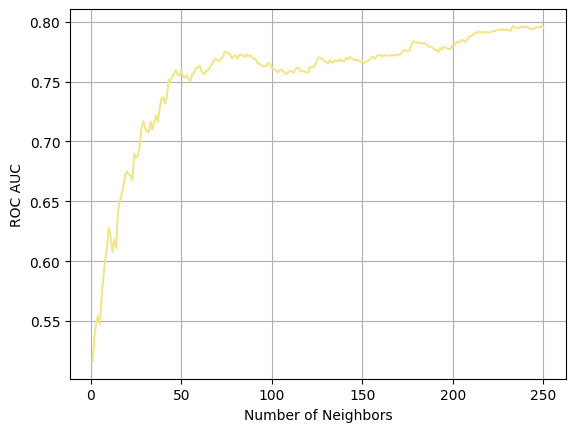

In [40]:
knn_accuracy_scores = []
for i in range(1, 251):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_scaled, y_train)
    knn_accuracy_scores.append(roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1]))

plt.plot(range(1, 251), knn_accuracy_scores, color = 'khaki')
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC AUC')
plt.grid(True)



In [41]:
print("Оптимальное число соседей :", np.argmax(knn_accuracy_scores) + 1)
print("Лучший ROC AUC:", np.max(knn_accuracy_scores))

Оптимальное число соседей : 233
Лучший ROC AUC: 0.7964971686562595


# логрег

In [42]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)

In [43]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [44]:
logreg_accuracy = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])
logreg_accuracy

0.7912457912457913

In [45]:
print("ROC AUC на логреге:", logreg_accuracy)

ROC AUC на логреге: 0.7912457912457913


In [46]:
iterations_values = [10, 15, 20, 25, 50, 75, 100]
learning_rate_values = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
depth_values = [2, 3, 4, 5]

best_roc_auc = 0
best_params = {}

for iterations in iterations_values:
    for learning_rate in learning_rate_values:
        for depth in depth_values:
            catboost_model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, random_state=19)
            catboost_model.fit(X_train, y_train)
            y_test_proba = catboost_model.predict_proba(X_test)[:, 1]  
            roc_auc = roc_auc_score(y_test, y_test_proba)
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_params = {'iterations': iterations, 'learning_rate': learning_rate, 'depth': depth}

0:	learn: 0.6730947	total: 11.2ms	remaining: 101ms
1:	learn: 0.6540565	total: 12.2ms	remaining: 48.7ms
2:	learn: 0.6359137	total: 12.8ms	remaining: 29.9ms
3:	learn: 0.6185752	total: 13.3ms	remaining: 19.9ms
4:	learn: 0.6020748	total: 13.5ms	remaining: 13.5ms
5:	learn: 0.5863494	total: 13.8ms	remaining: 9.2ms
6:	learn: 0.5712910	total: 14.1ms	remaining: 6.04ms
7:	learn: 0.5568693	total: 14.3ms	remaining: 3.59ms
8:	learn: 0.5430807	total: 14.6ms	remaining: 1.62ms
9:	learn: 0.5298647	total: 14.8ms	remaining: 0us
0:	learn: 0.6731711	total: 875us	remaining: 7.88ms
1:	learn: 0.6543048	total: 12ms	remaining: 48ms
2:	learn: 0.6361402	total: 12.8ms	remaining: 29.9ms
3:	learn: 0.6187940	total: 13.5ms	remaining: 20.3ms
4:	learn: 0.6022023	total: 13.9ms	remaining: 13.9ms
5:	learn: 0.5865279	total: 14.2ms	remaining: 9.49ms
6:	learn: 0.5715347	total: 14.6ms	remaining: 6.24ms
7:	learn: 0.5572709	total: 14.9ms	remaining: 3.72ms
8:	learn: 0.5436027	total: 15.2ms	remaining: 1.69ms
9:	learn: 0.5303372	to

In [47]:
print("Best parameters: ", best_params)
print("Best ROC-AUC score: ", best_roc_auc)

Best parameters:  {'iterations': 75, 'learning_rate': 0.05, 'depth': 3}
Best ROC-AUC score:  0.8279193449647996


# В результате во всех случаях качество заметно просело. Без возраста предсказывать значительно сложнее.

Более того, логрег начал показывать худший перформанс, чем KNN, что может говорить о зависимости между возрастом и таргетом, как хорошо аппроксимируемой линейной зависимостью

Бустинг и логрег лучше всего показали себя. Бустинг - мощная ансамблевая модель, позволяющая искать сложные зависимости. Неплохой перформанс логрега может объясняться наличием окололинейных зависимостей. KNN в данном случае перформит хуже остальных алгоритмов, что объясняется его примитивностью, а также большой размерностью признаков.


Мы научились (на этом, возможно, наивном датасете) неплохо предсказывать инсульты, и довольно очевидные гипотезы о важности возраста, индекса массы тела и количеством сахара в крови подтвердились.